In [1]:
# ==================== CELDA 1: PREPARACIÓN INICIAL ====================
import os
import shutil
print("--- FASE 0: Configuración y Descarga ---")

print("Limpiando el entorno...")
!rm -rf tr_im tr_mask data_png *.zip *.keras

print("Descargando los datasets...")
!wget -q "https://zenodo.org/records/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1" -O images.zip
!wget -q "https://zenodo.org/records/3757476/files/Lung_and_Infection_Mask.zip?download=1" -O masks.zip

print("Creando carpetas de destino y descomprimiendo...")
!mkdir tr_im
!mkdir tr_mask
!unzip -o -q images.zip -d tr_im/
!unzip -o -q masks.zip -d tr_mask/

print("--- ¡Entorno listo! ---")

--- FASE 0: Configuración y Descarga ---
Limpiando el entorno...
Descargando los datasets...
Creando carpetas de destino y descomprimiendo...
--- ¡Entorno listo! ---


In [3]:
# ==================== CELDA 2: PROCESAMIENTO Y CARGA DE DATOS ====================
print("--- FASE 1: Procesando y Cargando los Datos ---")

!pip install -q nibabel
import tensorflow as tf, numpy as np, nibabel as nib, cv2, matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 16
original_image_dir, original_mask_dir = 'tr_im', 'tr_mask'
base_dir = 'data_png'
train_dir, val_dir = os.path.join(base_dir, 'train'), os.path.join(base_dir, 'val')
train_images_dir, train_masks_dir = os.path.join(train_dir, 'images'), os.path.join(train_dir, 'masks')
val_images_dir, val_masks_dir = os.path.join(val_dir, 'images'), os.path.join(val_dir, 'masks')

if os.path.exists(base_dir): shutil.rmtree(base_dir)
os.makedirs(train_images_dir); os.makedirs(train_masks_dir); os.makedirs(val_images_dir); os.makedirs(val_masks_dir)

def convert_nii_to_png(source_folder, dest_folder, file_list):
    for file_name in file_list:
        img_data = nib.load(os.path.join(source_folder, file_name)).get_fdata()
        for i in range(img_data.shape[2]):
            slice_data = np.rot90(img_data[:, :, i])
            if np.max(slice_data) > 0: slice_data = 255 * (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))
            cv2.imwrite(os.path.join(dest_folder, f"{file_name.replace('.nii.gz', '')}_slice_{i:03d}.png"), slice_data.astype(np.uint8))

all_files = sorted([f for f in os.listdir(original_image_dir) if f.endswith('.nii.gz')])
split_index = int(len(all_files) * 0.8)
train_files, val_files = all_files[:split_index], all_files[split_index:]

print("Convirtiendo y organizando archivos...")
convert_nii_to_png(original_image_dir, train_images_dir, train_files)
convert_nii_to_png(original_mask_dir, train_masks_dir, train_files)
convert_nii_to_png(original_image_dir, val_images_dir, val_files)
convert_nii_to_png(original_mask_dir, val_masks_dir, val_files)

def normalize(image): return tf.cast(image, tf.float32) / 255.0
def load_png_dataset(image_dir, mask_dir):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])
    def process_path(img_path, msk_path):
        img = tf.image.decode_png(tf.io.read_file(img_path), channels=1); msk = tf.image.decode_png(tf.io.read_file(msk_path), channels=1)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE]); msk = tf.image.resize(msk, [IMG_SIZE, IMG_SIZE])
        return normalize(img), normalize(msk)
    return tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(image_files), tf.data.Dataset.from_tensor_slices(mask_files))).map(process_path)
def augment_data(image, mask):
    seed = tf.random.uniform(shape=[2], dtype=tf.int32, minval=0, maxval=2**31 - 1)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed); mask = tf.image.stateless_random_flip_left_right(mask, seed=seed)
    return image, mask

print("Cargando datos en TensorFlow...")
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = load_png_dataset(train_images_dir, train_masks_dir).map(augment_data, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = load_png_dataset(val_images_dir, val_masks_dir).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("--- ¡Datos listos! ---")

--- FASE 1: Procesando y Cargando los Datos ---
Convirtiendo y organizando archivos...
Cargando datos en TensorFlow...
--- ¡Datos listos! ---


In [4]:
# ==================== CELDA 3: CONSTRUCCIÓN DEL MODELO (TRANSFER LEARNING) ====================
print("--- FASE 2: Construyendo el Modelo U-Net con Transfer Learning ---")
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_with_transfer_learning(input_size=(224, 224, 1)):
    inputs = Input(input_size)
    inputs_rgb = Conv2D(3, (1, 1), padding='same')(inputs)

    base_model = MobileNetV2(input_shape=(input_size[0], input_size[1], 3), include_top=False, weights='imagenet')
    base_model.trainable = False # Congelamos el encoder

    skip_names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu', 'block_13_expand_relu']
    encoder_output_layer = base_model.get_layer('out_relu').output

    encoder_model = Model(inputs=base_model.input, outputs=[encoder_output_layer] + [base_model.get_layer(name).output for name in skip_names])

    all_outputs = encoder_model(inputs_rgb)
    bottleneck, skips = all_outputs[0], all_outputs[1:][::-1]

    u = bottleneck
    for i, skip_filters in enumerate([256, 128, 64, 32]):
        u = UpSampling2D(size=(2, 2))(u)
        u = concatenate([u, skips[i]])
        u = Conv2D(skip_filters, (3, 3), activation='relu', padding='same')(u)
        u = Conv2D(skip_filters, (3, 3), activation='relu', padding='same')(u)

    u = UpSampling2D(size=(2, 2))(u)
    c = Conv2D(32, (3, 3), activation='relu', padding='same')(u)
    c = Conv2D(32, (3, 3), activation='relu', padding='same')(c)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c)

    return Model(inputs=inputs, outputs=outputs)

model = unet_with_transfer_learning(input_size=(IMG_SIZE, IMG_SIZE, 1))
model.summary()
print("\n--- ¡Fase 2 completada! ---")

--- FASE 2: Construyendo el Modelo U-Net con Transfer Learning ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │          6 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 7, 7,     │  2,257,984 │ conv2d[0][0]      │
│ (Functional)        │ 1280), (None,     │            │                   │
│                     │ 112, 112, 96),    │            │                   │
│                     │ (None, 56, 56,    │            │                   │
│                     │ 144), (None, 28,  │            │                   │
│                     │ 28, 192), (None,  │            │                   │
│                     │ 14, 14, 576)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 14, 14,    │          0 │ functional[0][0]  │
│ (UpSampling2D)      │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 1856)             │            │ functional[0][4]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │  4,276,480 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │    590,080 │ conv2d_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 448)              │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    516,224 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 272)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    156,736 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                 

 Total params: 8,055,911 (30.73 MB)

 Trainable params: 5,797,927 (22.12 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- ¡Fase 2 completada! ---


In [9]:
# ==================== CELDA 4: COMPILACIÓN Y ENTRENAMIENTO ====================
print("--- FASE 3 y 4: Compilando y Entrenando el Modelo ---")
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true); y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def combined_loss(y_true, y_pred):
    return K.mean(tf.keras.losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)

callbacks = [
    # Cambiamos a monitorizar la pérdida de validación y guardamos cuando sea la mínima.
    ModelCheckpoint('mejor_modelo_final.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
]

model.compile(optimizer='adam', loss=combined_loss, metrics=[MeanIoU(num_classes=2, name='mean_iou')])

EPOCHS = 50
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)
print("--- ¡Entrenamiento finalizado! ---")

--- FASE 3 y 4: Compilando y Entrenando el Modelo ---
Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.4481 - mean_iou: 0.4904
Epoch 1: val_loss improved from inf to 0.37891, saving model to mejor_modelo_final.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 69s 236ms/step - loss: 0.4478 - mean_iou: 0.4903 - val_loss: 0.3789 - val_mean_iou: 0.4855 - learning_rate: 0.0010
Epoch 2/50
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3776 - mean_iou: 0.4903
Epoch 2: val_loss did not improve from 0.37891
207/207 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - loss: 0.3776 - mean_iou: 0.4903 - val_loss: 0.4255 - val_mean_iou: 0.4855 - learning_rate: 0.0010
Epoch 3/50
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3623 - mean_iou: 0.4907
Epoch 3: val_loss improved from 0.37891 to 0.36025, saving model to mejor_modelo_final.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - loss: 0.3622 - mean_iou: 0.4907 - val_loss: 0.3602 - val_mean_iou: 0.4855 - learning_rate: 0.0010
Epoch 4/50
206/207 ━━

In [10]:
# ==================== CELDA DE AJUSTE FINO 1 ====================

# 'model' es la variable de nuestro modelo con Transfer Learning que ya entrenamos

# Obtenemos la capa que contiene nuestro encoder.
encoder_layer_name = 'functional' 
base_model = model.get_layer(encoder_layer_name)

# 1. Descongelamos el encoder completo
print(f"Descongelando la capa del encoder ('{encoder_layer_name}')...")
base_model.trainable = True

# 2. Congelamos las capas iniciales del encoder
# Dejamos que solo las últimas capas se re-entrenen (ajuste fino).
fine_tune_at = 100
print(f"Congelando las primeras {fine_tune_at} capas del encoder...")
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Re-compilamos el modelo con una tasa de aprendizaje (learning rate) MUY BAJA.
# Esto es crucial para no destruir los pesos pre-entrenados con ajustes bruscos
print("Re-compilando el modelo con un learning rate bajo para el ajuste fino...")
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer_fine_tune,
              loss=combined_loss,
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

print("\nModelo re-compilado y listo para el Fine-Tuning.")
model.summary()

Descongelando la capa del encoder ('functional')...
Congelando las primeras 100 capas del encoder...
Re-compilando el modelo con un learning rate bajo para el ajuste fino...

Modelo re-compilado y listo para el Fine-Tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │          6 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 7, 7,     │  2,257,984 │ conv2d[0][0]      │
│ (Functional)        │ 1280), (None,     │            │                   │
│                     │ 112, 112, 96),    │            │                   │
│                     │ (None, 56, 56,    │            │                   │
│                     │ 144), (None, 28,  │            │                   │
│                     │ 28, 192), (None,  │            │                   │
│                     │ 14, 14, 576)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 14, 14,    │          0 │ functional[0][0]  │
│ (UpSampling2D)      │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 1856)             │            │ functional[0][4]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │  4,276,480 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │    590,080 │ conv2d_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 448)              │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    516,224 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 272)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    156,736 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                 

 Total params: 8,055,911 (30.73 MB)

 Trainable params: 5,797,927 (22.12 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# ==================== CELDA DE AJUSTE FINO 2: CONTINUAR ENTRENAMIENTO ====================

# Guardamos el número de épocas que ya entrenamos
initial_epochs = len(history.epoch)
fine_tune_epochs = 20 # Entrenaremos por 20 épocas más
total_epochs = initial_epochs + fine_tune_epochs

print(f"\n--- INICIANDO FINE-TUNING DESDE LA ÉPOCA {initial_epochs} ---")

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], #Le decimos que continúe desde donde se quedó
    validation_data=val_dataset,
    callbacks=callbacks 
)


--- INICIANDO FINE-TUNING DESDE LA ÉPOCA 19 ---
Epoch 19/39
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.3305 - mean_iou: 0.4911
Epoch 19: val_loss did not improve from 0.35286
207/207 ━━━━━━━━━━━━━━━━━━━━ 68s 231ms/step - loss: 0.3305 - mean_iou: 0.4911 - val_loss: 0.3541 - val_mean_iou: 0.4855 - learning_rate: 1.0000e-05
Epoch 20/39
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3340 - mean_iou: 0.4908
Epoch 20: val_loss did not improve from 0.35286
207/207 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - loss: 0.3339 - mean_iou: 0.4908 - val_loss: 0.3544 - val_mean_iou: 0.4855 - learning_rate: 1.0000e-05
Epoch 21/39
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3318 - mean_iou: 0.4910
Epoch 21: val_loss did not improve from 0.35286
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - loss: 0.3318 - mean_iou: 0.4910 - val_loss: 0.3555 - val_mean_iou: 0.4855 - learning_rate: 1.0000e-05
Epoch 22/39
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3327 - mean_iou: 0.4913
Epoch 2


--- FASE 5: Analizando Resultados Finales ---

Cargando el mejor modelo guardado durante todo el entrenamiento...

Evaluando el rendimiento del mejor modelo en el conjunto de validación...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3537 - mean_iou: 0.4879
--------------------------------------------------
Pérdida final en validación: 0.3529
IoU final en validación: 0.4855
--------------------------------------------------


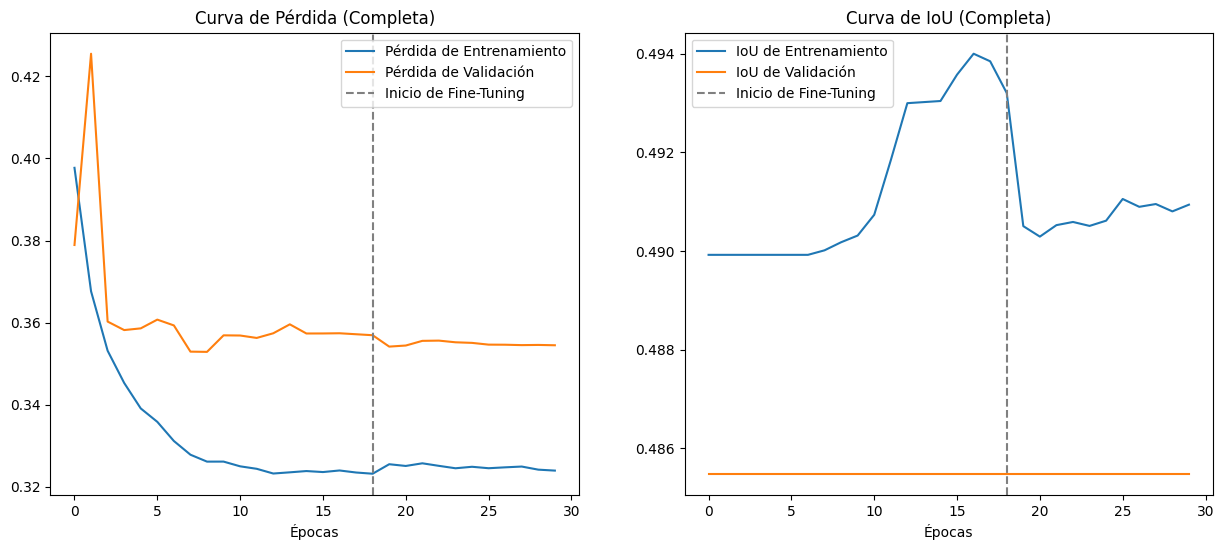


Generando predicciones visuales del modelo final...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


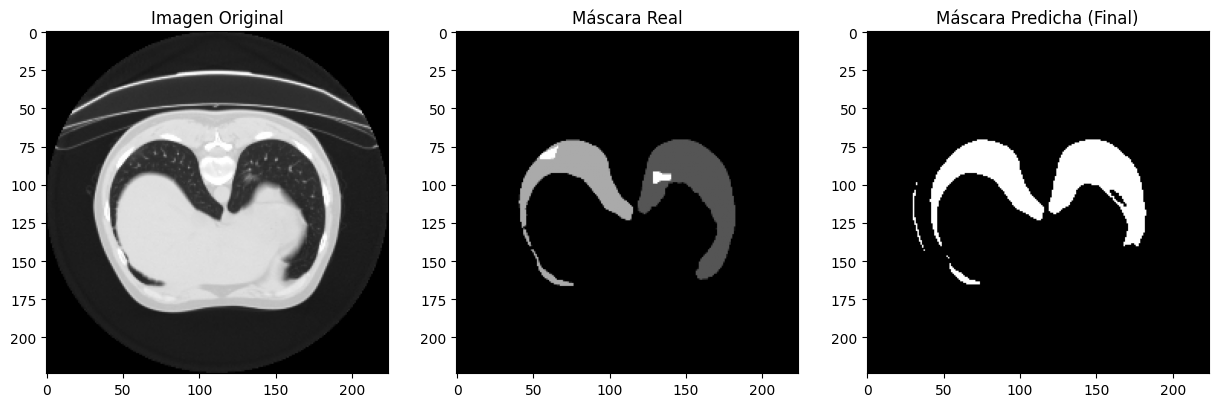

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


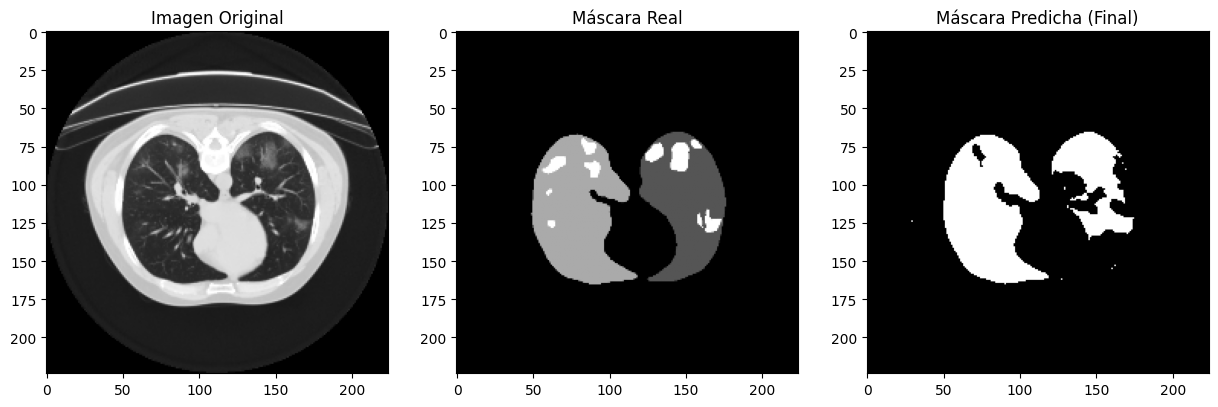

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


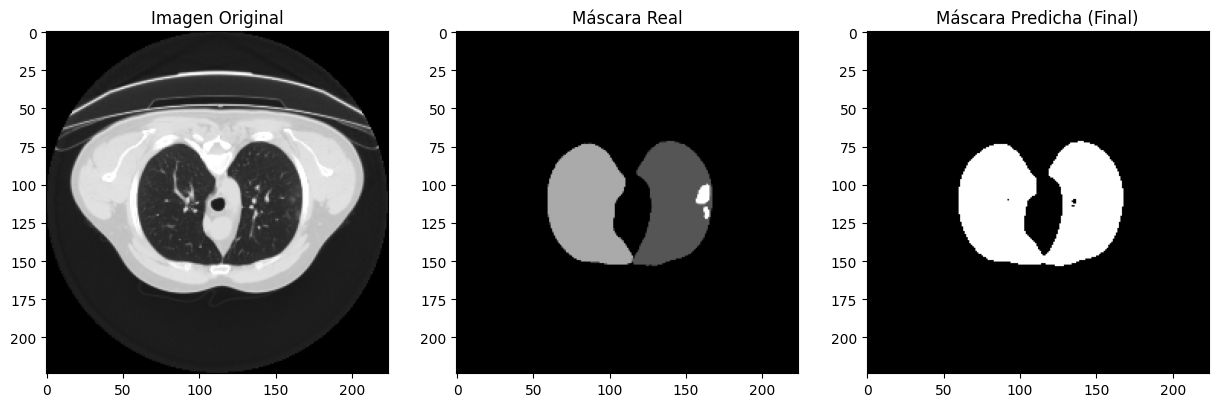

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


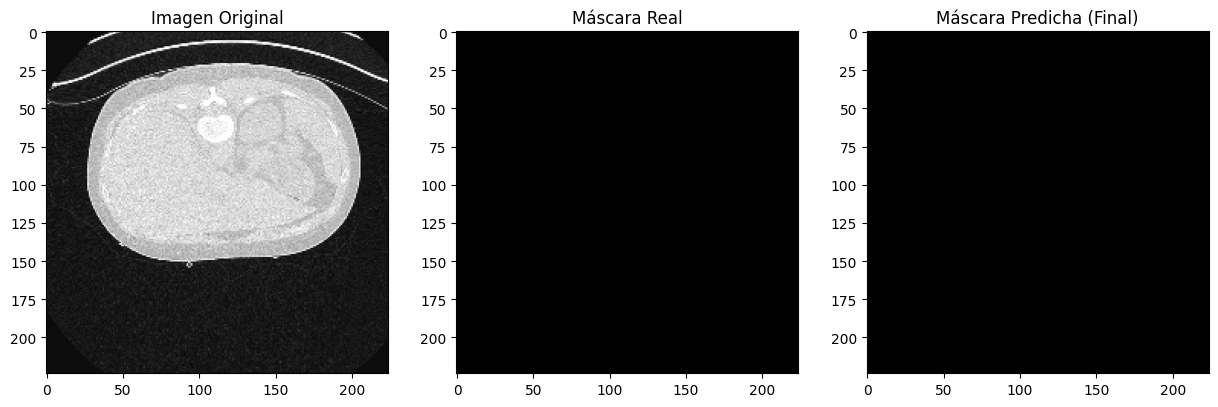

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


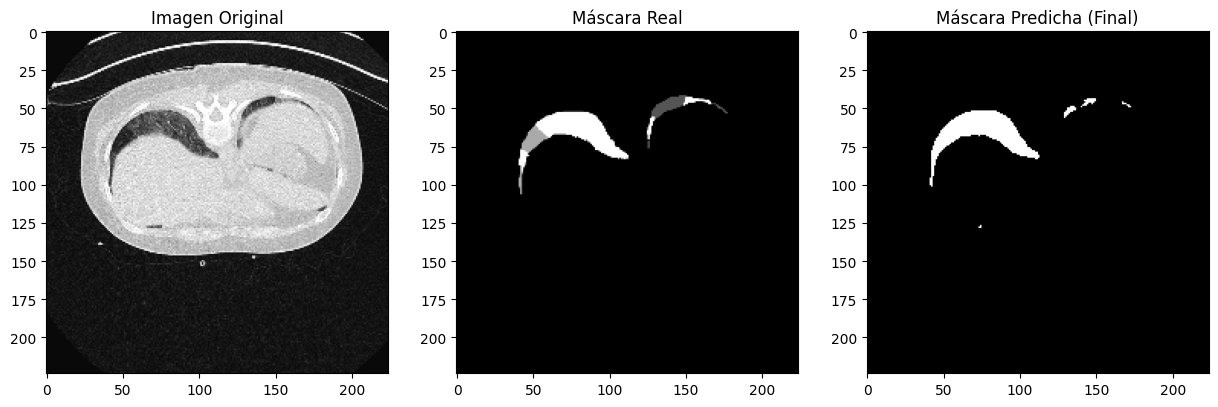


--- ¡PROYECTO FINALIZADO! ---


In [12]:
# ==================== CELDA DE EVALUACIÓN FINAL (CORREGIDA) ====================
import matplotlib.pyplot as plt
import numpy as np

print("\n--- FASE 5: Analizando Resultados Finales ---\n")

# 1. CARGAR EL MEJOR MODELO GUARDADO
print("Cargando el mejor modelo guardado durante todo el entrenamiento...")
model.load_weights('mejor_modelo_final.keras')

# 2. EVALUACIÓN NUMÉRICA FINAL
print("\nEvaluando el rendimiento del mejor modelo en el conjunto de validación...")
results = model.evaluate(val_dataset)
print("-" * 50)
print(f"Pérdida final en validación: {results[0]:.4f}")
print(f"IoU final en validación: {results[1]:.4f}")
print("-" * 50)


# 3. COMBINAR HISTORIALES DE ENTRENAMIENTO
# 'history' es de la primera fase, 'history_fine_tune' es de la segunda.
acc = history.history['mean_iou'] + history_fine_tune.history['mean_iou']
val_acc = history.history['val_mean_iou'] + history_fine_tune.history['val_mean_iou']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']


# 4. GRÁFICOS DEL PROCESO COMPLETO
plt.figure(figsize=(15, 6))

# Gráfico de Pérdida
plt.subplot(1, 2, 1)
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
# Dibuja una línea vertical para separar las dos fases de entrenamiento
plt.axvline(len(history.history['loss']) - 1, color='gray', linestyle='--', label='Inicio de Fine-Tuning')
plt.title('Curva de Pérdida (Completa)')
plt.xlabel('Épocas')
plt.legend()

# Gráfico de IoU
plt.subplot(1, 2, 2)
plt.plot(acc, label='IoU de Entrenamiento')
plt.plot(val_acc, label='IoU de Validación')
# Dibuja la misma línea vertical
plt.axvline(len(history.history['val_mean_iou']) - 1, color='gray', linestyle='--', label='Inicio de Fine-Tuning')
plt.title('Curva de IoU (Completa)')
plt.xlabel('Épocas')
plt.legend()

plt.show()


# 5. VISUALIZACIÓN DE PREDICCIONES (esto se mantiene igual)
def mostrar_predicciones(dataset, num_samples=5):
    print("\nGenerando predicciones visuales del modelo final...")
    for image, mask in dataset.take(num_samples):
        pred_mask = (model.predict(image) > 0.5).astype(np.uint8)
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(image[0]), cmap='gray')
        plt.title('Imagen Original')
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(mask[0]), cmap='gray')
        plt.title('Máscara Real')
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(pred_mask[0]), cmap='gray')
        plt.title('Máscara Predicha (Final)')
        plt.show()

mostrar_predicciones(val_dataset)
print("\n--- ¡PROYECTO FINALIZADO! ---")